**Generalizing the Galton Board to n_layers**

We have designed our package to generate any circuit of a Galton board with `n_layers` to achieve a Gaussian-like distribution using the circuit logic introduced in the *Universal Statistical Simulator* paper.

We will explore this architecture throughout this notebook, discuss the circuit’s properties, and explain how to achieve different variations of the Gaussian-like distribution using Qiskit and PennyLane.

---

1. **The Gaussian (Normal) Probability Distribution:**

In probability theory and statistics, a Gaussian (Normal) distribution is a type of **continuous** probability distribution for a real-valued random variable. The general form of its probability density function can be described as follows:

$$
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$

whith $\mu$ the expectation and $\sigma$ the standrad deviation

---

2. **The Binomial Distribution:**

The binomial distribution is the **discrete** probability distribution of the number of successes in a sequence of ***n*** independent experiments, each asking a yes–no question, and each with its own Boolean-valued outcome: success (with probability ***p***) or failure (with probability *q = 1 − p*). It can be described through the following probability mass function:

$$
P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

---
3. **De Moivre–Laplace Theorem:**

This theorem, which is a special case of the Central Limit Theorem, states that the probability mass function of the **discrete** binomial distribution will converge towards the probability density function of the **continuous** normal distribution as ***n*** **grows large**, with expectation $\mu = np$ and standard deviation $\sigma = \sqrt{np(1-p)}$

---

4. **Our Case:**

The circuit of the Quantum Galton Board with a number of layers `n_layers` produces **discrete probability distributions** of size `n_layers + 1`.

To achieve real convergence toward continuous distributions, we need to increase the number of layers (which will be computationally efficient — we will see this in other tasks).

The methods and objects are called **Gaussian**, although what we are actually trying to approximate is the **binomial distribution** we have. We kept the Gaussian naming to stay in line with the project description.

---

5. **The Quantum Circuit:**

The QGBx package supports two noiseless backends: `PennylaneDefaultQubit` and `QiskitAerSimulator`. We will explore the quantum circuit using both

First we need to understand how the peg works un the USS paper logic:


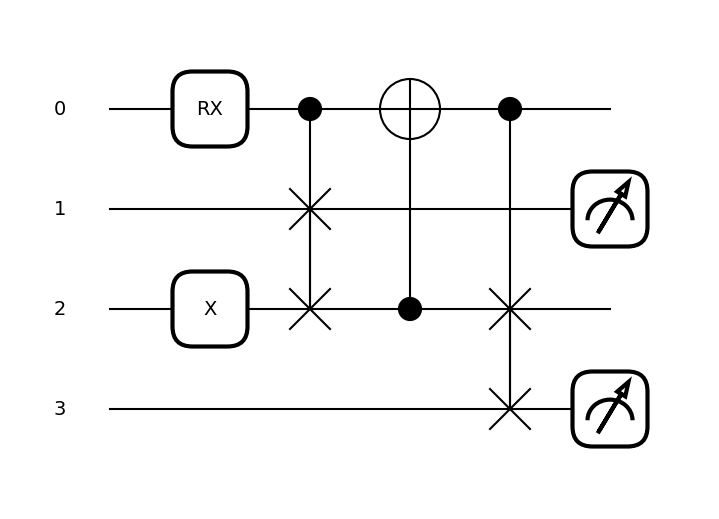

In [3]:
##### You can refer to the package documentation to understand its pipeline
import QGBx
from QGBx.distributions import Gaussian
from QGBx.devices import PennylanDefaultQubit


dev = PennylanDefaultQubit(shots = 1000)
dist = Gaussian(dev, p = 0.5)
gen = QGBx.Generator(dev, dist)
gen.galton_board(1)
gen.draw_circuit()

The ball is represented on wire number 02 and can go up (through the first CSWAP) to wire number 01, or go down (through the second CSWAP) to wire number 03.

The CNOT in the middle serves to flip the control qubit in order to apply the second CSWAP on the other state (which was desactivated) (like making the control value is 0 instead of 1)

This operation is controlled by the qubit on wire number 0, which is initialized by the RX($\pi/2$) gate (similar to the Hadamard gate) and creates an equal superposition to control the CSWAP operations. This simulates going through a peg with a 50-50 chance of going up or down.

We note that changing the angle of the RX gate will change the probability of going up or down, which helps us create a biased version of the Gaussian distribution (and enables other interesting variations in other tasks).


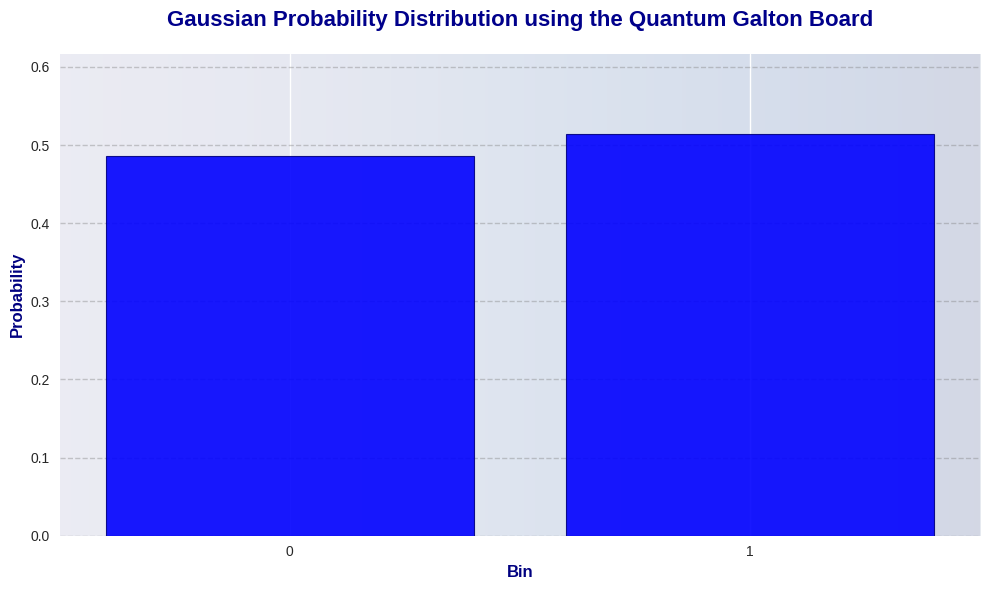

In [6]:
gen.run()
QGBx.Visualiser(dist).plot()

The peg is well calibrated, which is why we get a 50% chance of going up and a 50% chance of going down.

We can produce unbiased probabilities by changing the `p` argument of the Gaussian object:


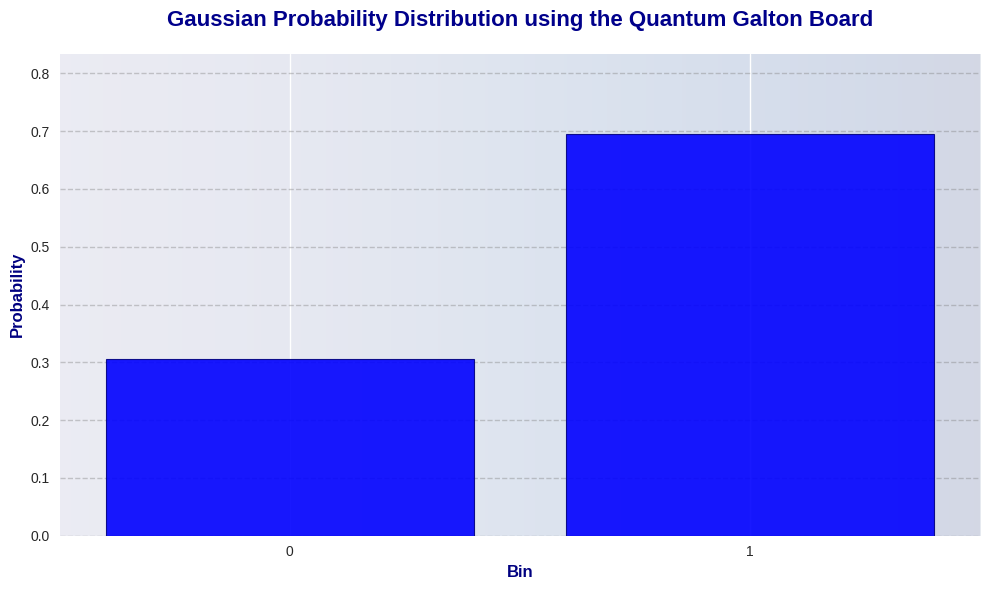

In [7]:
dist = Gaussian(dev, p = 0.7)
gen = QGBx.Generator(dev, dist)
gen.galton_board(1)
gen.run()
QGBx.Visualiser(dist).plot()

Results arent perfect due to the stochastic nature of the process...

Now by chaining this pegs structure according to the galton board architetecture we can simulate the galton board behavior

Let's see the circuit of a 3-layers galton board:



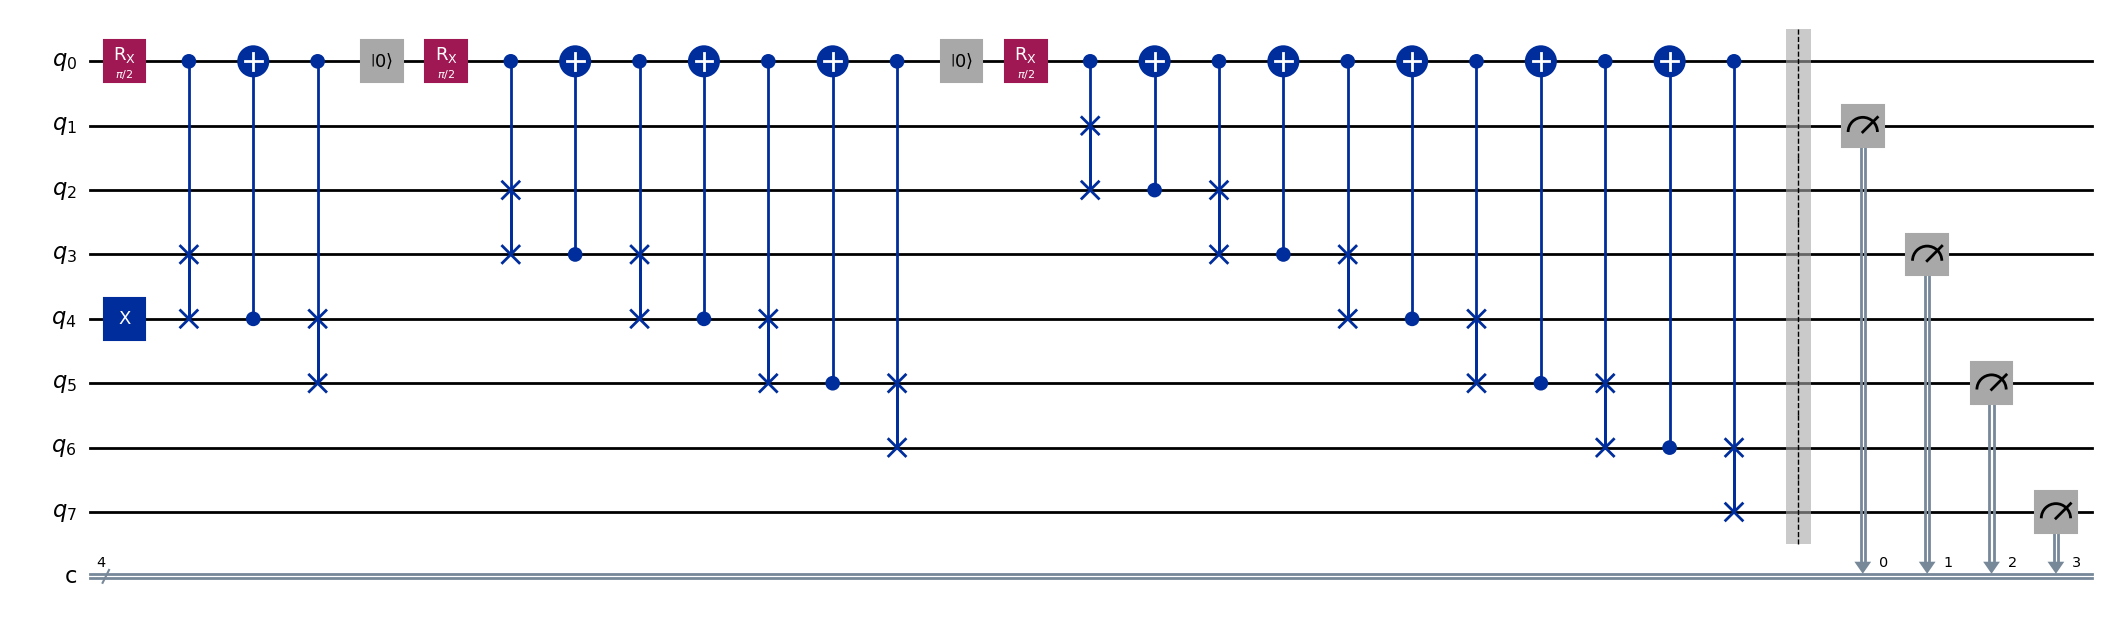

In [4]:
from QGBx.devices import QiskitAerSimulator
dev = QiskitAerSimulator(shots = 1000)
dist = Gaussian(dev, p = 0.5)
gen = QGBx.Generator(dev, dist)
gen.galton_board(3)
#gen.daw_circuit()
dev.draw_circuit()

We can see that after all layer we destroy the control_qubit state and reset it to 0, this is essential to assure that all the pegs have the same proability and to prevent the interference between the superpositioning gate effect (The RX or the Hdamard gate), the CNOTs after each peg serves to returns the control qubit probability to 50%, which then allows us to proceed onto implementing a quantum peg for the other half of the circuit.

Following the logic of the USS circuit for `n_layers`, we have:

- Number of final qubits = \(2 \times (n\_layers + 1)\)
- Number of bins = \(n\_layers + 1\)
- Position of the ball qubit = \(n\_layers + 1\)
- Ball measurement wires = `[ball_qubit + i for i in range(-n_layers, n_layers + 1, 2)]`

You can check the algorith of generalization in the package source code...

Bascally here it is:

```
def circuit(self, n_layers):
       
        self.number_of_layers = n_layers
        num_qubits = 2 * (n_layers + 1)
        control_qubit = 0
        ball_qubit = n_layers + 1
        ball_measure_wires = [ball_qubit + i for i in range(-n_layers, n_layers + 1, 2)]
        
            @qml.qnode(self.dev(wires=num_qubits))
            def gaussian_circuit():
                angle = rx_angles_from_probabilities(self.p).item()
                qml.RX(angle, wires=control_qubit)
                qml.PauliX(wires=ball_qubit)

                for layer in range(n_layers):
                    offset = layer
                    positions = [
                        ball_qubit + pos
                        for pos in range(-offset, offset + 1, 2)
                        if 0 < ball_qubit + pos < num_qubits - 1
                    ]

                    for j, i in enumerate(positions):
                        peg(i)
                        if j < len(positions) - 1:
                            qml.CNOT(wires=[i + 1, control_qubit])

                    if layer < n_layers - 1:
                        m = qml.measure(wires=control_qubit)
                        qml.cond(m, qml.PauliX)(wires=control_qubit)
                        qml.RX(angle, wires=control_qubit)

                return qml.sample(wires=ball_measure_wires)
```





---

We now generate and visualize a Gaussian probability distribution with different numbers of layers and parameters, and benchmark the results against the ideal distribution:



**n_layers = 3 | p = 0.5**


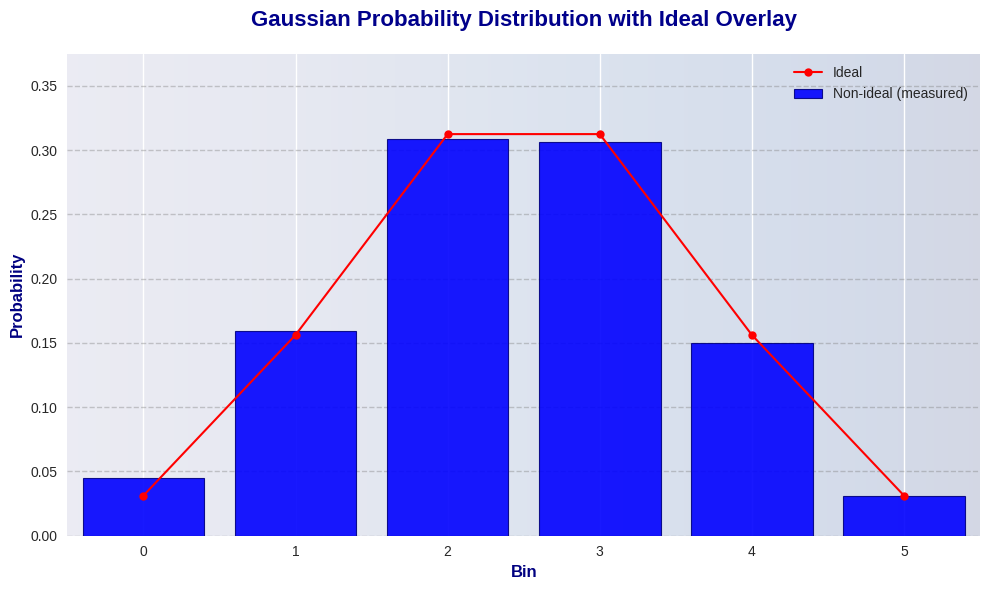

In [19]:
dist = Gaussian(dev, p = 0.5)
gen = QGBx.Generator(dev, dist)
gen.galton_board(5)
gen.run()
QGBx.Visualiser(dist).plot_with_ideal()

**n_layers = 6 | p = 0.5**

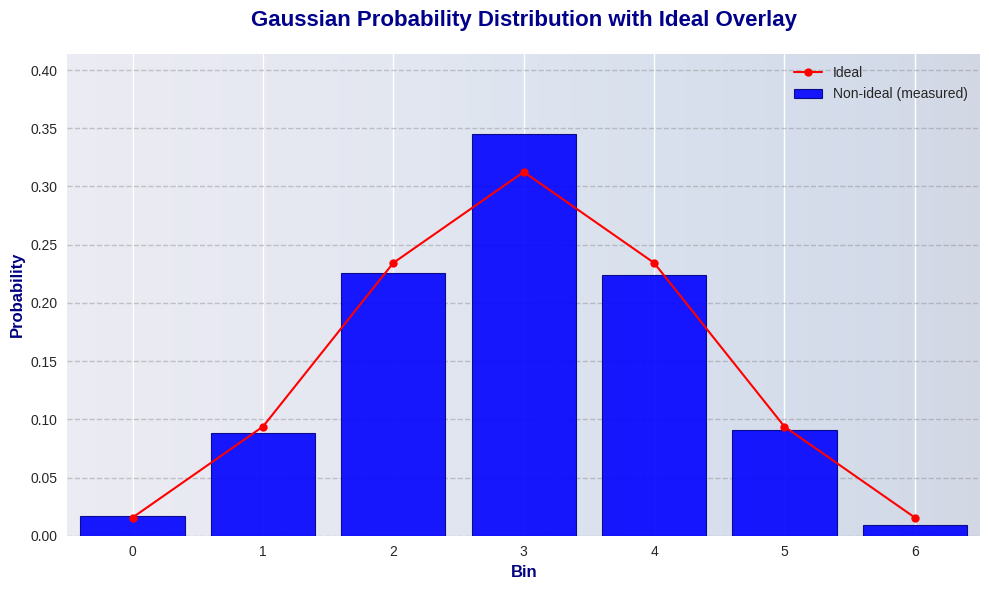

In [20]:
dist = Gaussian(dev, p = 0.5)
gen = QGBx.Generator(dev, dist)
gen.galton_board(6)
gen.run()
QGBx.Visualiser(dist).plot_with_ideal()